In [144]:
import numpy as np
import matplotlib.pyplot as plt
from skeleton import *
from scipy.optimize import curve_fit

Simulation temperature  119.8 K
(108, 3) (108, 3)
126.62205257011405


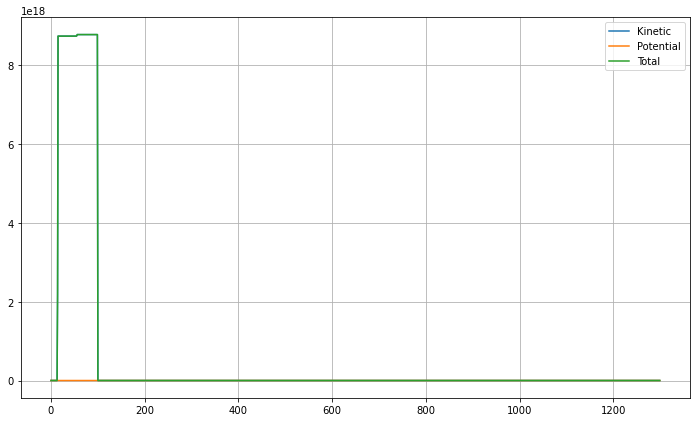

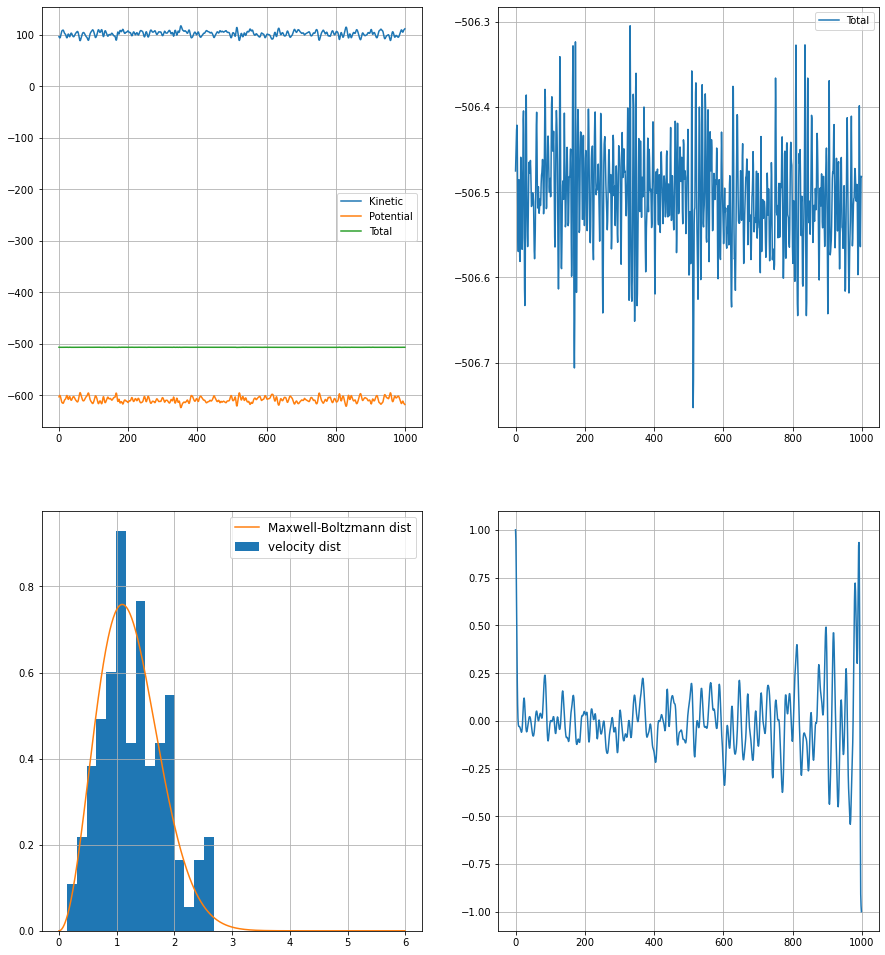

In [59]:
"""Adjustable variables"""
Dim_T = 119.8

T_dim = 1
N = 108
Rho = 0.8

T = T_dim*Dim_T
V = N/Rho
L = V**(1/3)
N_cell = (N/4)**(1/3)
alpha = L/(N_cell + 0.001)

D = 3 # number of dimentions
h = 500 # number of time steps

offset = np.asarray([1,1,1]) * 0.1


print('Simulation temperature ',T,'K')
temp = T

# size of the square box the particles are simulated in
#L, alpha = cell_dim(N,'l',temp)

#r0, v0 = init_fcc(L, alpha, offset, temp)
r0, v0 = init_rv_uniform(D, N, L)
v0 = init_v_gauss(N, temp)

start_temp = system_temperature(v0)
print(r0.shape, v0.shape)

N = r0.shape[0]

R, V = gen_rv_matrices(D,N,h) # generating matrices for storage
R, V = store_rv(R,V,r0,v0,0) # storing initial condions in matrix

R, V, pott, r1, v1 = equalise_system(r0, v0, temp, L, grace_time=100, error=1, timespacing=1e-5, adaptive=True)

Kinetic_E_eq = np.sum(np.sum(V**2/ 2,2),1)
Potential_E_eq = np.sum(pott,1)
Total_E_eq = Kinetic_E_eq+Potential_E_eq

plt.figure(figsize = (12,7))
plt.plot(Kinetic_E_eq, label= 'Kinetic')
plt.plot(Potential_E_eq, label= 'Potential')
plt.plot(Total_E_eq, label= 'Total')
plt.legend()
plt.grid()

#Creating a new simulation starting from equilibrium
h = 1000

R, V = gen_rv_matrices(D,N,h) # generating matrices for storage
R, V = store_rv(R,V,r1,v1,0) # storing initial condions in matrix

Rt, Vt, forcet, pott = Verlet_integrate_images(N, R, V, 1, h, 0, L, D=3, timespacing=1e-2)

Kinetic_E = np.sum(np.sum(Vt**2/ 2,2),1)
Potential_E = np.sum(pott,1)
Total_E = Kinetic_E+Potential_E

t = np.arange(0,h,1)

new_value = Vt[-1,:,:] ** 2 @ np.ones([D,1])
bins = 15

v = np.arange(0,6,0.01)
MB_dist = MB_distribution(v,temp)

Temp_calc = system_temperature(Vt)
print(np.sum(Temp_calc)/h)
auto_corr_T = finite_autocorr(Temp_calc)

plt.figure(figsize = (15,17))

plt.subplot(221)
plt.plot(t, Kinetic_E, label= 'Kinetic')
plt.plot(t, Potential_E, label= 'Potential')
plt.plot(t, Total_E, label= 'Total')
plt.legend()
plt.grid()

plt.subplot(222)
plt.plot(t, Total_E, label= 'Total')
plt.legend()
plt.grid()

plt.subplot(223)
plt.hist(np.sqrt(new_value), bins, density = 'True', label='velocity dist')
plt.plot(v,MB_dist, label='Maxwell-Boltzmann dist')
plt.legend(fontsize='large')
plt.grid()

plt.subplot(224)
plt.plot(auto_corr_T)
plt.grid()
plt.show()

np.save('../Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_Rt',Rt)
np.save('../Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_Vt',Vt)
np.save('../Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_forcet',forcet)
np.save('../Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_pott',pott)

In [269]:
"""Load the data"""
N = 108
D = 3
dt = 1e-2
dim_T = 119.8

V_gas = np.load('Data/Data_Marc/Simulation_Gas_Temp_3.0_108_par_un_dis_2_Vt.npy')
R_gas = np.load('Data/Data_Marc/Simulation_Gas_Temp_3.0_108_par_un_dis_2_Rt.npy')
Pot_gas = np.load('Data/Data_Marc/Simulation_Gas_Temp_3.0_108_par_un_dis_2_pott.npy')

V_liq = np.load('Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_Vt.npy')
R_liq = np.load('Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_Rt.npy')
Pot_liq = np.load('Data/Data_Marc/Simulation_Liquid_Temp_1_108_par_un_dis_1_pott.npy')

V_sol = np.load('Data/Data_Marc/Simulation_Solid_Temp_0.5_108_par_un_dis_1_Vt.npy')
R_sol = np.load('Data/Data_Marc/Simulation_Solid_Temp_0.5_108_par_un_dis_1_Rt.npy')
Pot_sol = np.load('Data/Data_Marc/Simulation_Solid_Temp_0.5_108_par_un_dis_1_pott.npy')

In [270]:
"""Calculate & plot the energies"""
def calc_all_E(Velocities, Potentials):
    E_kin = np.sum(np.sum(Velocities**2 /2, 2), 1)
    E_pot = np.sum(Potentials, 1)
    E_tot = E_kin + E_pot
    return E_kin, E_pot, E_tot

def exp_func(t,tau):
    return np.exp(-t/ tau)

In [276]:
E_kin_gas, E_pot_gas, E_tot_gas = calc_all_E(V_gas, Pot_gas)
E_kin_liq, E_pot_liq, E_tot_liq = calc_all_E(V_liq, Pot_liq)
E_kin_sol, E_pot_sol, E_tot_sol = calc_all_E(V_sol, Pot_sol)

Avg_Tot_gas = np.sum(E_tot_gas)/np.size(E_tot_gas)*np.ones([np.size(E_tot_gas),])/N
Avg_Tot_liq = np.sum(E_tot_liq)/np.size(E_tot_liq)*np.ones([np.size(E_tot_liq),])/N
Avg_Tot_sol = np.sum(E_tot_sol)/np.size(E_tot_sol)*np.ones([np.size(E_tot_sol),])/N

t_gas = np.arange(0,np.size(E_kin_gas),1)*dt
t_liq = np.arange(0,np.size(E_kin_liq),1)*dt
t_sol = np.arange(0,np.size(E_kin_sol),1)*dt

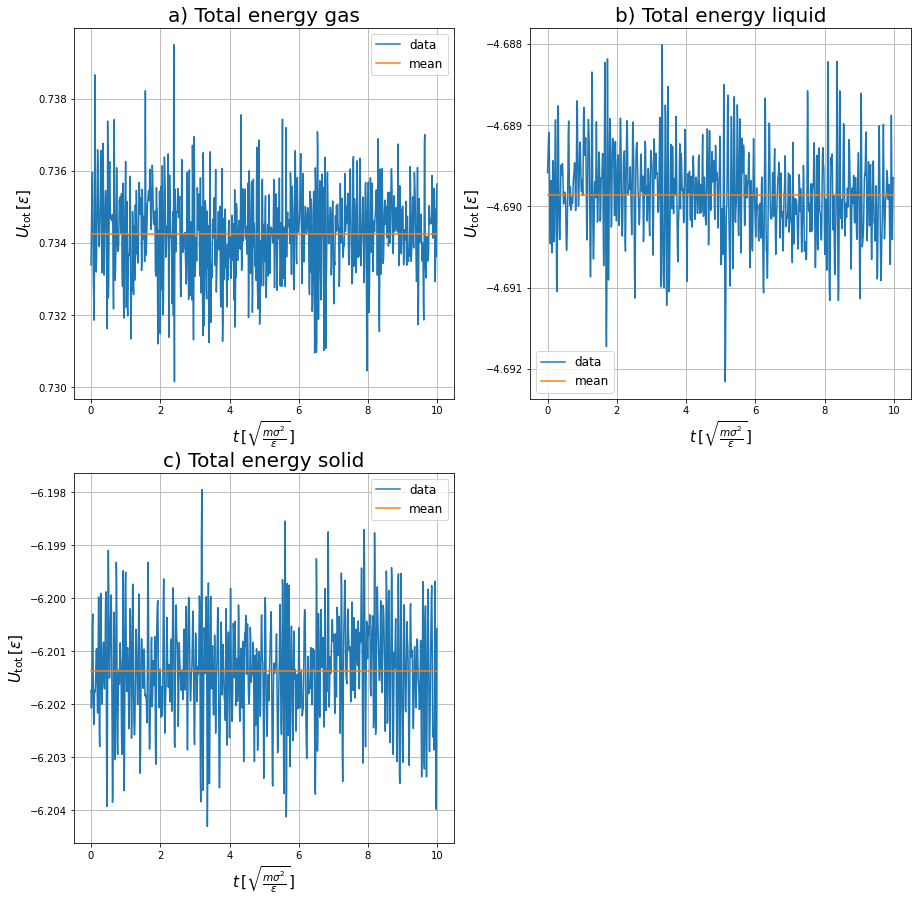

In [280]:
plt.figure(figsize = (15,15))
plt.subplot(221)
plt.plot(t_gas,E_tot_gas/N, label = 'data')
plt.plot(t_gas,Avg_Tot_gas, label = 'mean')
plt.title('a) Total energy gas', fontsize = 20)
plt.xlabel(r"$t \, [\sqrt{\frac{m\sigma^2}{\epsilon}}]$", fontsize = 15)
plt.ylabel(r"$U_\mathrm{tot} \, [\epsilon]$", fontsize = 15)
plt.grid()
plt.legend(fontsize = 'large')
plt.subplot(222)
plt.plot(t_liq,E_tot_liq/N, label = 'data')
plt.plot(t_liq,Avg_Tot_liq, label = 'mean')
plt.title('b) Total energy liquid', fontsize = 20)
plt.xlabel(r"$t \, [\sqrt{\frac{m\sigma^2}{\epsilon}}]$", fontsize = 15)
plt.ylabel(r"$U_\mathrm{tot} \, [\epsilon]$", fontsize = 15)
plt.grid()
plt.legend(fontsize = 'large')
plt.subplot(223)
plt.plot(t_sol,E_tot_sol/N, label = 'data')
plt.plot(t_sol,Avg_Tot_sol, label = 'mean')
plt.title('c) Total energy solid', fontsize = 20)
plt.xlabel(r"$t \, [\sqrt{\frac{m\sigma^2}{\epsilon}}]$", fontsize = 15)
plt.ylabel(r"$U_\mathrm{tot} \, [\epsilon]$", fontsize = 15)
plt.grid()
plt.legend(fontsize = 'large')
plt.savefig('../figs/Graphs_Marc/Total_energy_for_different_phases.png')
plt.show()

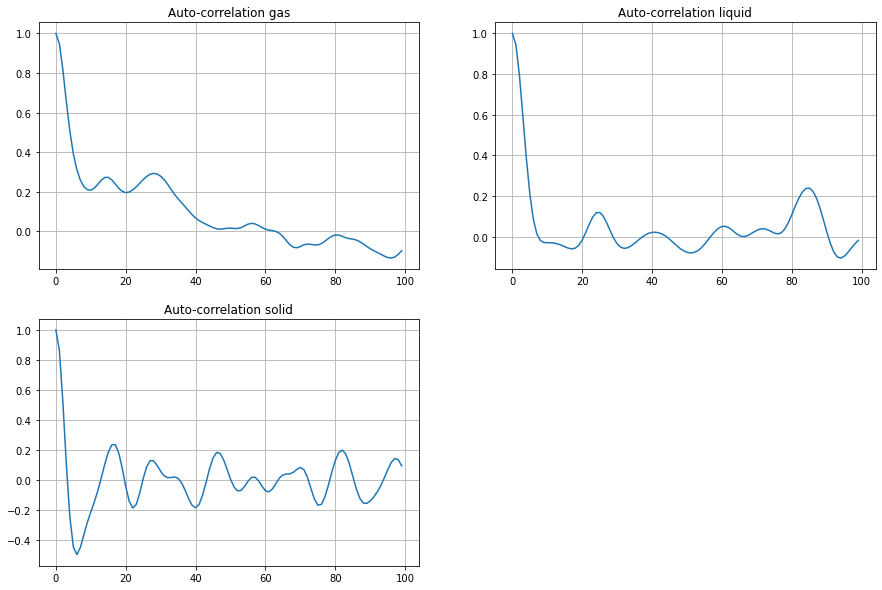

In [246]:
T_gas = system_temperature(V_gas)/dim_T
T_liq = system_temperature(V_liq)/dim_T
T_sol = system_temperature(V_sol)/dim_T

auto_corr_T_gas = finite_autocorr(T_gas)
auto_corr_T_liq = finite_autocorr(T_liq)
auto_corr_T_sol = finite_autocorr(T_sol)

plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(auto_corr_T_gas[0:100])
plt.title('Auto-correlation gas')
plt.grid()
plt.subplot(222)
plt.plot(auto_corr_T_liq[0:100])
plt.title('Auto-correlation liquid')
plt.grid()
plt.subplot(223)
plt.plot(auto_corr_T_sol[0:100])
plt.title('Auto-correlation solid')
plt.grid()
plt.show()

In [113]:
print(np.shape(T_gas))

(1000,)


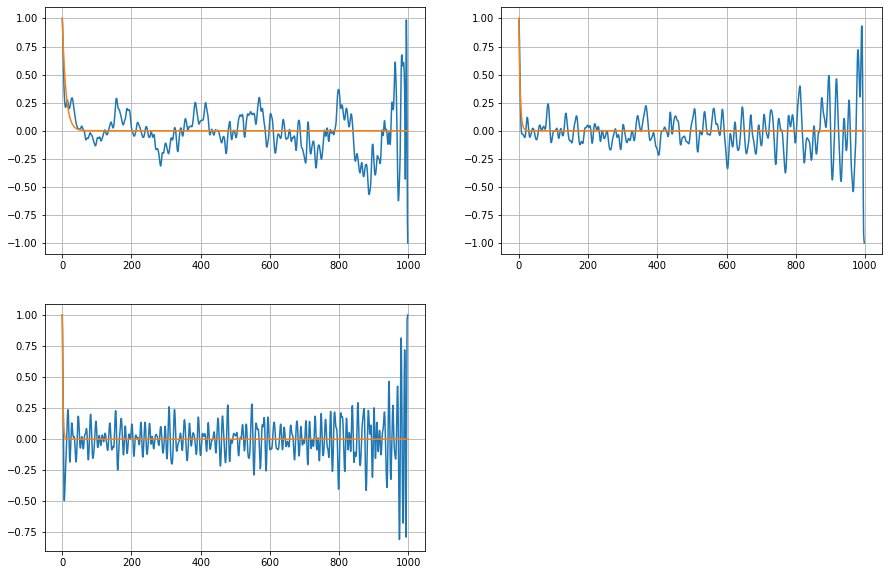

Temperature gas =  2.9915820252673266
error temperature gas =  [0.01209343]
tau gas =  [0.10277247]

Temperature liq =  1.0569453469959436
error temperature liq =  [0.00445091]
tau liq =  [0.03781683]

Temperature sol =  0.817476600369285
error temperature sol =  [0.00289367]
tau sol =  [0.01974782]


In [250]:
t0_gas = 60
t0_liq = 10
t0_sol = 5

popt_T_gas, pcov_T_gas = curve_fit(exp_func, t_gas[0:t0_gas], auto_corr_T_gas[0:t0_gas])
popt_T_liq, pcov_T_liq = curve_fit(exp_func, t_liq[0:t0_liq], auto_corr_T_liq[0:t0_liq])
popt_T_sol, pcov_T_sol = curve_fit(exp_func, t_sol[0:t0_sol], auto_corr_T_sol[0:t0_sol])

plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(auto_corr_T_gas, label = 'auto-corration')
plt.plot(exp_func(t_gas,popt_T_gas), label = 'fit')
plt.grid()
plt.subplot(222)
plt.plot(auto_corr_T_liq, label = 'auto-corration')
plt.plot(exp_func(t_liq,popt_T_liq), label = 'fit')
plt.grid()
plt.subplot(223)
plt.plot(auto_corr_T_sol, label = 'auto-corration')
plt.plot(exp_func(t_sol,popt_T_sol), label = 'fit')
plt.grid()
plt.show()

error_data_T_gas = error(T_gas, popt_T_gas/1e-2)
error_data_T_liq = error(T_liq, popt_T_liq/1e-2)
error_data_T_sol = error(T_sol, popt_T_sol/1e-2)

print('Temperature gas = ',np.sum(T_gas)/ np.size(T_gas))
print('error temperature gas = ',error_data_T_gas)
print('tau gas = ',popt_T_gas)
print()
print('Temperature liq = ',np.sum(T_liq)/ np.size(T_liq))
print('error temperature liq = ',error_data_T_liq)
print('tau liq = ',popt_T_liq)
print()
print('Temperature sol = ',np.sum(T_sol)/ np.size(T_sol))
print('error temperature sol = ',error_data_T_sol)
print('tau sol = ',popt_T_sol)


In [233]:
bins = 15

new_value_gas = V_gas[-1,:,:] ** 2 @ np.ones([D,1])
new_value_liq = V_liq[-1,:,:] ** 2 @ np.ones([D,1])
new_value_sol = V_sol[-1,:,:] ** 2 @ np.ones([D,1])

Temp_gas = np.sum(T_gas)/ np.size(T_gas)
Temp_liq = np.sum(T_liq)/ np.size(T_liq)
Temp_sol = np.sum(T_sol)/ np.size(T_sol)


v = np.arange(0,6,0.01)
MB_dist_gas = MB_distribution(v,Temp_gas*119.8)
MB_dist_liq = MB_distribution(v,Temp_liq*119.9)
MB_dist_sol = MB_distribution(v,Temp_sol*119.8)

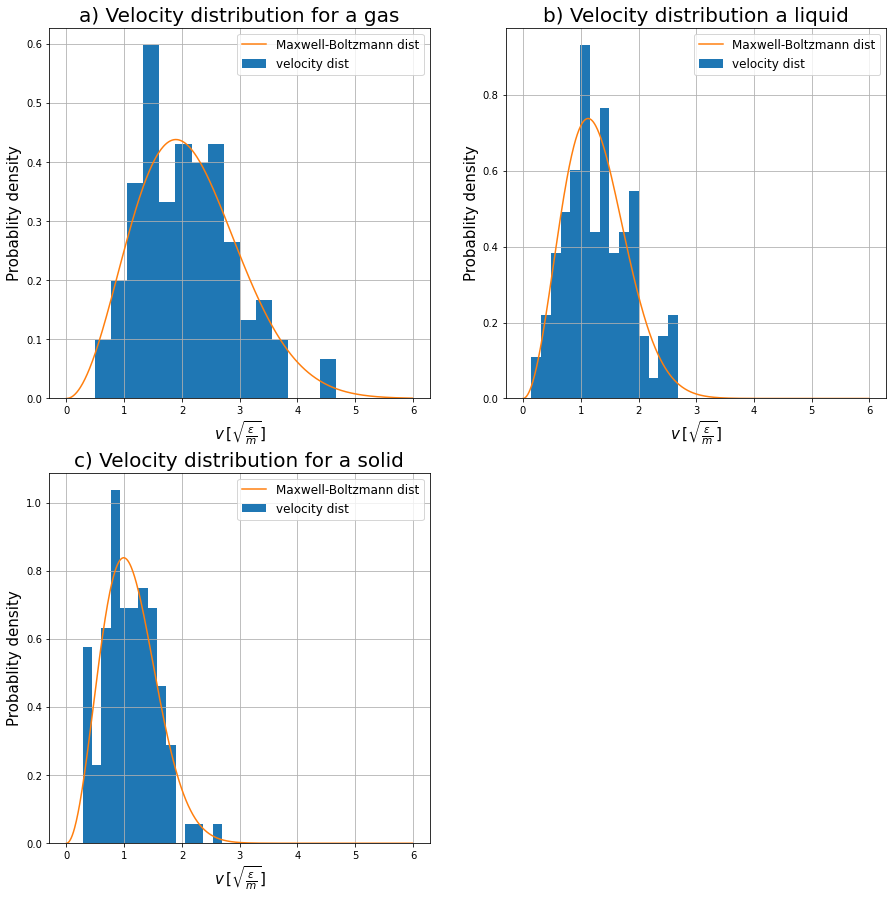

In [238]:
plt.figure(figsize = (15,15))
plt.subplot(221)
plt.hist(np.sqrt(new_value_gas), bins, density = 'True', label='velocity dist')
plt.plot(v,MB_dist_gas, label='Maxwell-Boltzmann dist')
plt.title('a) Velocity distribution for a gas', fontsize = 20)
plt.xlabel(r"$v \, [\sqrt{\frac{\epsilon}{m}}]$", fontsize = 15)
plt.ylabel('Probablity density', fontsize = 15)
plt.legend(fontsize='large')
plt.grid()

plt.subplot(222)
plt.hist(np.sqrt(new_value_liq), bins, density = 'True', label='velocity dist')
plt.plot(v,MB_dist_liq, label='Maxwell-Boltzmann dist')
plt.title('b) Velocity distribution a liquid', fontsize = 20)
plt.xlabel(r"$v \, [\sqrt{\frac{\epsilon}{m}}]$", fontsize = 15)
plt.ylabel('Probablity density', fontsize = 15)
plt.legend(fontsize='large')
plt.grid()

plt.subplot(223)
plt.hist(np.sqrt(new_value_sol), bins, density = 'True', label='velocity dist')
plt.plot(v,MB_dist_sol, label='Maxwell-Boltzmann dist')
plt.title('c) Velocity distribution for a solid', fontsize = 20)
plt.xlabel(r"$v \, [\sqrt{\frac{\epsilon}{m}}]$", fontsize = 15)
plt.ylabel('Probablity density', fontsize = 15)
plt.legend(fontsize='large')
plt.grid()
plt.savefig('../figs/Graphs_Marc/MB_dist_different_phases.png')
plt.show()

## New part

In [146]:
"""Adjustable variables"""
Dim_T = 119.8

T_dim = 1
N = 108
Rho = 0.8

T = T_dim*Dim_T
V = N/Rho
L = V**(1/3)
N_cell = (N/4)**(1/3)
alpha = L/(N_cell + 0.001)

D = 3 # number of dimentions
h1 = 400 # number of time steps
h = 500

offset = np.asarray([1,1,1]) * 0.1
temp = T

Num_sim = 3
sim = np.arange(0,Num_sim,1)

Kin = np.zeros([Num_sim, h1])
Pot = np.zeros([Num_sim, h1])
Temp = np.zeros([Num_sim, h1])


for i in sim:
    # size of the square box the particles are simulated in
    #L, alpha = cell_dim(N,'l',temp)
    
    #r0, v0 = init_fcc(L, alpha, offset, temp)
    r0, v0 = init_rv_uniform(D, N, L)
    v0 = init_v_gauss(N, temp)
    
    start_temp = system_temperature(v0)
    
    N = r0.shape[0]
    
    R, V = gen_rv_matrices(D,N,h) # generating matrices for storage
    R, V = store_rv(R,V,r0,v0,0) # storing initial condions in matrix
    
    R, V, pott, r1, v1 = equalise_system(r0, v0, temp, L, grace_time=100, error=1, timespacing=1e-5, adaptive=True)
    
    #Creating a new simulation starting from equilibrium
    
    h = h1
    
    R, V = gen_rv_matrices(D,N,h) # generating matrices for storage
    R, V = store_rv(R,V,r1,v1,0) # storing initial condions in matrix
    
    Rt, Vt, forcet, pott = Verlet_integrate_images(N, R, V, 1, h, 0, L, D=3, timespacing=1e-2)
    
    Kinetic_E = np.sum(np.sum(Vt**2/ 2,2),1)
    Potential_E = np.sum(pott,1)
    Total_E = Kinetic_E+Potential_E
    
    Temp_calc = system_temperature(Vt)/Dim_T    
    
    print(np.sum(Temp_calc)/h)
    
    Kin[i,:] = Kinetic_E
    Pot[i,:] = Potential_E
    Temp[i,:] = Temp_calc
    
np.save('../Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_2_Kin',Kin)
np.save('../Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_2_Pot',Pot)
np.save('../Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_2_Temp',Temp)


0.9844695967737264
1.04584785607628
0.9977098188360206


In [251]:
Kin_E1 = np.load('Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_1_Kin.npy')
Kin_E2 = np.load('Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_2_Kin.npy')
sim1, h = np.shape(Kin_E1)
sim2, h = np.shape(Kin_E2)

Kin_E = np.zeros([sim1+sim2,h])
Kin_E[0:sim1,:] = Kin_E1
Kin_E[sim1:,:] = Kin_E2


Pot_E1 = np.load('Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_1_Pot.npy')
Pot_E2 = np.load('Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_2_Pot.npy')

Pot_E = np.zeros([sim1+sim2,h])
Pot_E[0:sim1,:] = Pot_E1
Pot_E[sim1:,:] = Pot_E2


Temp_1 = np.load('Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_1_Temp.npy')
Temp_2 = np.load('Data/Data_Marc/20_Simulation_Liquid_Temp_1_32_par_un_dis_2_Temp.npy')

Temp = np.zeros([sim1+sim2,h])
Temp[0:sim1,:] = Temp_1
Temp[sim1:,:] = Temp_2

Evaluating the data

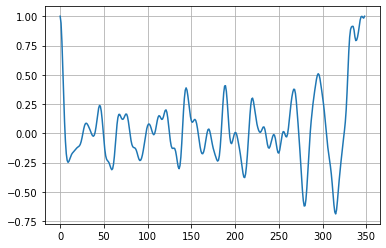

In [252]:

h0 = 50
Num_sim, h = np.shape(Kin_E)
sim = np.arange(0,Num_sim,1)

for i in [0]:
    auto_corr_T = finite_autocorr(Temp[i,h0:])
    
    plt.figure()
    plt.plot(auto_corr_T)
    plt.grid()
    plt.show()

Take the values of the temperature and energies after the first 50 time steps.

In [263]:
Num_sim, h = np.shape(Kin_E)
sim = np.arange(0,Num_sim,1)

t0 = [5,15,20,20,50,60]
h0 = 50

dh = h-h0

t = np.arange(0,dh,1)*1e-2

avg_T = np.zeros([Num_sim,])
tau_T = np.zeros([Num_sim,])
sig_T = np.zeros([Num_sim,])
avg_U = np.zeros([Num_sim,])

for i in sim:
    avg_T[i] = np.sum(Temp[i,h0:])/dh
    avg_U[i] = np.sum(Pot_E[i,h0:])/dh
    
    auto_corr_T = finite_autocorr(Temp[i,h0:])
    popt_T, pcov_T = curve_fit(exp_func, t[0:t0[i]], auto_corr_T[0:t0[i]])
    error_data_T = error(Temp, popt_T/1e-2)
    
    tau_T[i] = popt_T
    sig_T[i] = error_data_T

In [264]:
sig_T = np.array([sig_T[3], sig_T[5], sig_T[2], sig_T[0], sig_T[4]])
avg_T = np.array([avg_T[3], avg_T[5], avg_T[2], avg_T[0], avg_T[4]])
avg_U = np.array([avg_U[3], avg_U[5], avg_U[2], avg_U[0], avg_U[4]])/108

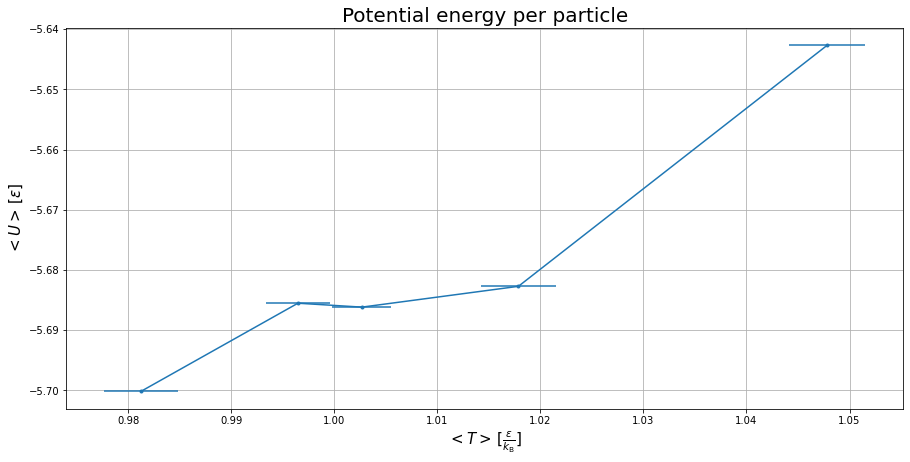

In [268]:


plt.figure(figsize = (15,7))
plt.errorbar(avg_T, avg_U, xerr=sig_T, marker = '.')
plt.xlabel(r"$ <T> \, [\frac{\epsilon}{k_\mathrm{B}}]$", fontsize = 15)
plt.ylabel(r"$\left< U\right> \, [\epsilon]$", fontsize = 15)
plt.title('Potential energy per particle', fontsize = 20)
plt.grid()
plt.savefig('../figs/Graphs_Marc/T_vs_U_liquid_Ar.png')
plt.show()